# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns

In [3]:
from icecream import ic

In [4]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dropblock import DropBlock2D

In [5]:
from dataset.cityscapes import Cityscapes
from dataset.cityscapes import CityscapesDataModule
from dataset.woodscape import WoodScapeDataset
from dataset.woodscape import WoodScapeDataModule
from dataset import WoodScapeSoilingDataset
from dataset import WoodScapeSoilingDataModule

In [6]:
from dataset.cityscapes import Cityscapes
from dataset.cityscapes import CityscapesDataModule
from dataset.woodscape import WoodScapeDataset
from dataset.woodscape import WoodScapeDataModule
from dataset import WoodScapeSoilingDataset
from dataset import WoodScapeSoilingDataModule

In [7]:
from utils.display_images import denormalize_img
from utils import show_dataset_image, show_dataset_mask
from utils import show_prediction_images, show_prediction_uncertainty_images

In [8]:
from deeplab_v3p import DeepLabV3PlusModule
from dropblock import DropBlock2D

In [9]:
from ls_ood_detect.uncertainty_estimation import Hook
from ls_ood_detect.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect.uncertainty_estimation import get_dl_h_z
from ls_ood_detect.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect.score import get_hz_scores
from ls_ood_detect.metrics import get_hz_detector_results
from ls_ood_detect.metrics import get_ood_detector_results
from ls_ood_detect.metrics import plot_roc_ood_detector
from ls_ood_detect.metrics import plot_auprc_ood_detector
from ls_ood_detect.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect.dimensionality_reduction import apply_pca_transform

# Load Entropy

In [10]:
data_path = "./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/"

In [11]:
cs_dlv3p_h_z_cs_normal_train_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_train_samples_np.npy')
cs_dlv3p_h_z_cs_normal_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_valid_samples_np.npy')
cs_dlv3p_h_z_cs_normal_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_test_samples_np.npy')

cs_dlv3p_h_z_cs_anomal_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_anomal_valid_samples_np.npy')
cs_dlv3p_h_z_cs_anomal_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_anomal_test_samples_np.npy')

cs_dlv3p_h_z_ws_256512_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_256512_valid_samples_np.npy')
cs_dlv3p_h_z_ws_256512_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_256512_test_samples_np.npy')

cs_dlv3p_h_z_ws_soil_256512_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.npy')
cs_dlv3p_h_z_ws_soil_256512_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_soil_256512_test_samples_np.npy')

# Entropy 2D Projection

(1000, 2048)
(1000, 1)
(1000, 2)


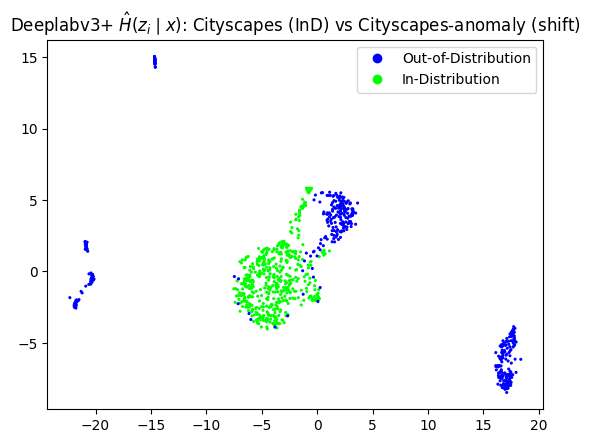

In [12]:
plot_samples_pacmap(cs_dlv3p_h_z_cs_normal_valid_samples_np,
                    cs_dlv3p_h_z_cs_anomal_valid_samples_np,
                    neighbors=14,
                    title="Deeplabv3+ $\hat{H}(z_i \mid x)$: Cityscapes (InD) vs Cityscapes-anomaly (shift)")

(1982, 2048)
(1982, 1)
(1982, 2)


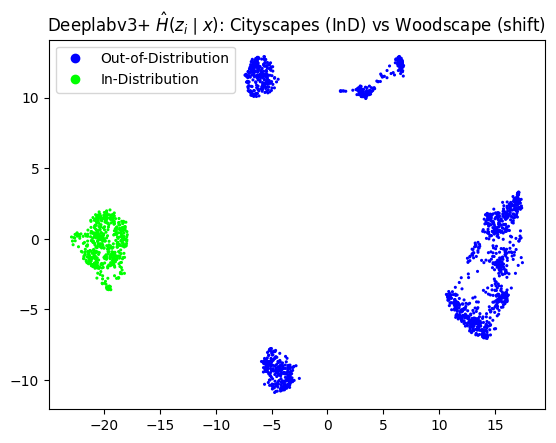

In [13]:
plot_samples_pacmap(cs_dlv3p_h_z_cs_normal_valid_samples_np,
                    cs_dlv3p_h_z_ws_256512_valid_samples_np,
                    neighbors=14,
                    title="Deeplabv3+ $\hat{H}(z_i \mid x)$: Cityscapes (InD) vs Woodscape (shift)")

(1300, 2048)
(1300, 1)
(1300, 2)


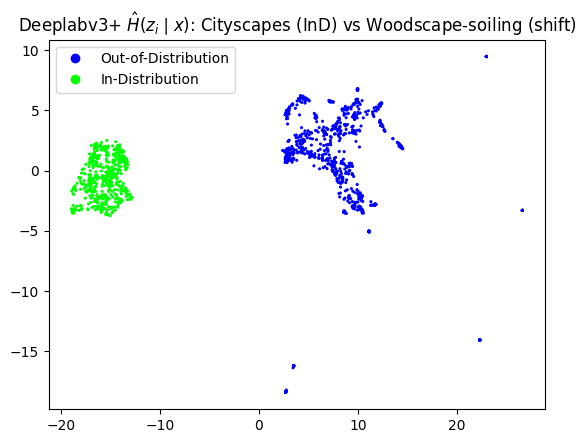

In [14]:
plot_samples_pacmap(cs_dlv3p_h_z_cs_normal_valid_samples_np,
                    cs_dlv3p_h_z_ws_soil_256512_valid_samples_np,
                    neighbors=14,
                    title="Deeplabv3+ $\hat{H}(z_i \mid x)$: Cityscapes (InD) vs Woodscape-soiling (shift)")

# Build Deeplabv3+ Cityscapes LaRED Distribution Shift Detector

In [112]:
ic(cs_dlv3p_h_z_cs_normal_train_samples_np.shape);
ic(cs_dlv3p_h_z_cs_normal_valid_samples_np.shape);
ic(cs_dlv3p_h_z_cs_normal_test_samples_np.shape);

ic(cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape);
ic(cs_dlv3p_h_z_cs_anomal_test_samples_np.shape);

ic(cs_dlv3p_h_z_ws_256512_valid_samples_np.shape);
ic(cs_dlv3p_h_z_ws_256512_test_samples_np.shape);

ic(cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape);
ic(cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape);

ic| cs_dlv3p_h_z_cs_normal_train_samples_np.shape: (2975, 2048)


ic| cs_dlv3p_h_z_cs_normal_valid_samples_np.shape: (500, 2048)
ic| cs_dlv3p_h_z_cs_normal_test_samples_np.shape: (1525, 2048)
ic| cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape: (500, 2048)
ic| cs_dlv3p_h_z_cs_anomal_test_samples_np.shape: (1525, 2048)
ic| cs_dlv3p_h_z_ws_256512_valid_samples_np.shape: (1482, 2048)
ic| cs_dlv3p_h_z_ws_256512_test_samples_np.shape: (823, 2048)
ic| cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape: (800, 2048)
ic| cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape: (1000, 2048)


## PCA Dimensionality Reduction

In [285]:
pca_cs_dlv3p_h_z_cs_normal_train_samples_np, pca_tr = apply_pca_ds_split(samples=cs_dlv3p_h_z_cs_normal_train_samples_np,
                                                                         nro_components=58)

In [286]:
pca_cs_dlv3p_h_z_cs_normal_valid_samples_np = apply_pca_transform(cs_dlv3p_h_z_cs_normal_valid_samples_np, pca_tr) # InD
pca_cs_dlv3p_h_z_cs_normal_test_samples_np = apply_pca_transform(cs_dlv3p_h_z_cs_normal_test_samples_np, pca_tr) # InD

pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np= apply_pca_transform(cs_dlv3p_h_z_cs_anomal_valid_samples_np, pca_tr) # OoD | Anomaly
pca_cs_dlv3p_h_z_cs_anomal_test_samples_np = apply_pca_transform(cs_dlv3p_h_z_cs_anomal_test_samples_np, pca_tr) # OoD | Anomaly

pca_cs_dlv3p_h_z_ws_256512_valid_samples_np = apply_pca_transform(cs_dlv3p_h_z_ws_256512_valid_samples_np, pca_tr) # OoD | Anomaly
pca_cs_dlv3p_h_z_ws_256512_test_samples_np = apply_pca_transform(cs_dlv3p_h_z_ws_256512_test_samples_np, pca_tr) # OoD | Anomaly

pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np = apply_pca_transform(cs_dlv3p_h_z_ws_soil_256512_valid_samples_np, pca_tr) # OoD | Anomaly
pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np = apply_pca_transform(cs_dlv3p_h_z_ws_soil_256512_test_samples_np, pca_tr) # OoD | Anomaly

In [287]:
ic(pca_cs_dlv3p_h_z_cs_normal_train_samples_np.shape);
ic(pca_cs_dlv3p_h_z_cs_normal_valid_samples_np.shape);
ic(pca_cs_dlv3p_h_z_cs_normal_test_samples_np.shape);

ic(pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape);
ic(pca_cs_dlv3p_h_z_cs_anomal_test_samples_np.shape);

ic(pca_cs_dlv3p_h_z_ws_256512_valid_samples_np.shape);
ic(pca_cs_dlv3p_h_z_ws_256512_test_samples_np.shape);

ic(pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape);
ic(pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape);

ic| pca_cs_dlv3p_h_z_cs_normal_train_samples_np.shape: (2975, 58)
ic| pca_cs_dlv3p_h_z_cs_normal_valid_samples_np.shape: (500, 58)
ic| pca_cs_dlv3p_h_z_cs_normal_test_samples_np.shape: (1525, 58)
ic| pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape: (500, 58)
ic| pca_cs_dlv3p_h_z_cs_anomal_test_samples_np.shape: (1525, 58)
ic| pca_cs_dlv3p_h_z_ws_256512_valid_samples_np.shape: (1482, 58)
ic| pca_cs_dlv3p_h_z_ws_256512_test_samples_np.shape: (823, 58)
ic| pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape: (800, 58)
ic| pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape: (1000, 58)


## Build Detector

In [288]:
cs_dlv3p_ds_shift_detector = DetectorKDE(train_embeddings=pca_cs_dlv3p_h_z_cs_normal_train_samples_np)

In [289]:
scores_pca_cs_dlv3p_h_z_cs_normal_valid_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                  pca_cs_dlv3p_h_z_cs_normal_valid_samples_np)

scores_pca_cs_dlv3p_h_z_cs_normal_test_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                  pca_cs_dlv3p_h_z_cs_normal_test_samples_np)


scores_pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                   pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np)

scores_pca_cs_dlv3p_h_z_cs_anomal_test_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                  pca_cs_dlv3p_h_z_cs_anomal_test_samples_np)


scores_pca_cs_dlv3p_h_z_ws_256512_valid_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                   pca_cs_dlv3p_h_z_ws_256512_valid_samples_np)

scores_pca_cs_dlv3p_h_z_ws_256512_test_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                  pca_cs_dlv3p_h_z_ws_256512_test_samples_np)


scores_pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                        pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np)

scores_pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np = get_hz_scores(cs_dlv3p_ds_shift_detector,
                                                                       pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np)


In [290]:
scores_pca_cs_dlv3p_ind_cs_normal_h_z = np.concatenate((scores_pca_cs_dlv3p_h_z_cs_normal_valid_samples_np,
                                                        scores_pca_cs_dlv3p_h_z_cs_normal_test_samples_np))

scores_pca_cs_dlv3p_ood_cs_anomal_h_z = np.concatenate((scores_pca_cs_dlv3p_h_z_cs_anomal_valid_samples_np,
                                                        scores_pca_cs_dlv3p_h_z_cs_anomal_test_samples_np))

scores_pca_cs_dlv3p_ood_ws_h_z = np.concatenate((scores_pca_cs_dlv3p_h_z_ws_256512_valid_samples_np,
                                                 scores_pca_cs_dlv3p_h_z_ws_256512_test_samples_np))

scores_pca_cs_dlv3p_ood_ws_soil_h_z = np.concatenate((scores_pca_cs_dlv3p_h_z_ws_soil_256512_valid_samples_np,
                                                      scores_pca_cs_dlv3p_h_z_ws_soil_256512_test_samples_np))

ic(scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_cs_anomal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_ws_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_ws_soil_h_z.shape);

ic| scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape: (2025,)


ic| scores_pca_cs_dlv3p_ood_cs_anomal_h_z.shape: (2025,)
ic| scores_pca_cs_dlv3p_ood_ws_h_z.shape: (2305,)
ic| scores_pca_cs_dlv3p_ood_ws_soil_h_z.shape: (1800,)


In [291]:
ic(scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_cs_anomal_h_z.shape);

results_ws_anomal = get_hz_detector_results(detect_exp_name="cityscapes vs. cityscapes-anomalies",
                                            ind_samples_scores=scores_pca_cs_dlv3p_ind_cs_normal_h_z,
                                            ood_samples_scores=scores_pca_cs_dlv3p_ood_cs_anomal_h_z)

ic| scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape: (2025,)


ic| scores_pca_cs_dlv3p_ood_cs_anomal_h_z.shape: (2025,)


AUROC: 0.9248
FPR95: 0.3235
AUPR: 0.9227


In [292]:
ic(scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_ws_h_z.shape);

results_cs = get_hz_detector_results(detect_exp_name="cityscapes vs. woodscape",
                                     ind_samples_scores=scores_pca_cs_dlv3p_ind_cs_normal_h_z,
                                     ood_samples_scores=scores_pca_cs_dlv3p_ood_ws_h_z)

ic| scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape: (2025,)
ic| scores_pca_cs_dlv3p_ood_ws_h_z.shape: (2305,)


AUROC: 0.9914
FPR95: 0.0026
AUPR: 0.9928


In [293]:
ic(scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape);
ic(scores_pca_cs_dlv3p_ood_ws_soil_h_z.shape);

results_ws_soil = get_hz_detector_results(detect_exp_name="cityscapes vs. woodscape-soiling",
                                          ind_samples_scores=scores_pca_cs_dlv3p_ind_cs_normal_h_z,
                                          ood_samples_scores=scores_pca_cs_dlv3p_ood_ws_soil_h_z)

ic| scores_pca_cs_dlv3p_ind_cs_normal_h_z.shape: (2025,)
ic| scores_pca_cs_dlv3p_ood_ws_soil_h_z.shape: (1800,)


AUROC: 0.9951
FPR95: 0.0000
AUPR: 0.9965


## Plot scores

In [294]:
df_score_ind_ws_normal = pd.DataFrame(scores_pca_cs_dlv3p_ind_cs_normal_h_z, columns=["LaRED score"])
df_score_ood_ws_anomal = pd.DataFrame(scores_pca_cs_dlv3p_ood_cs_anomal_h_z, columns=["LaRED score"])
df_score_ood_cs = pd.DataFrame(scores_pca_cs_dlv3p_ood_ws_h_z, columns=["LaRED score"])
df_score_ood_ws_soil = pd.DataFrame(scores_pca_cs_dlv3p_ood_ws_soil_h_z, columns=["LaRED score"])

df_score_ind_ws_normal.insert(0, "Dataset", "")
df_score_ind_ws_normal.loc[:, "Dataset"] = "InD-cityscapes-normal"

df_score_ood_ws_anomal.insert(0, "Dataset", "")
df_score_ood_ws_anomal.loc[:, "Dataset"] = "cityscapes-anomalies"

df_score_ood_cs.insert(0, "Dataset", "")
df_score_ood_cs.loc[:, "Dataset"] = "woodscape"

df_score_ood_ws_soil.insert(0, "Dataset", "")
df_score_ood_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

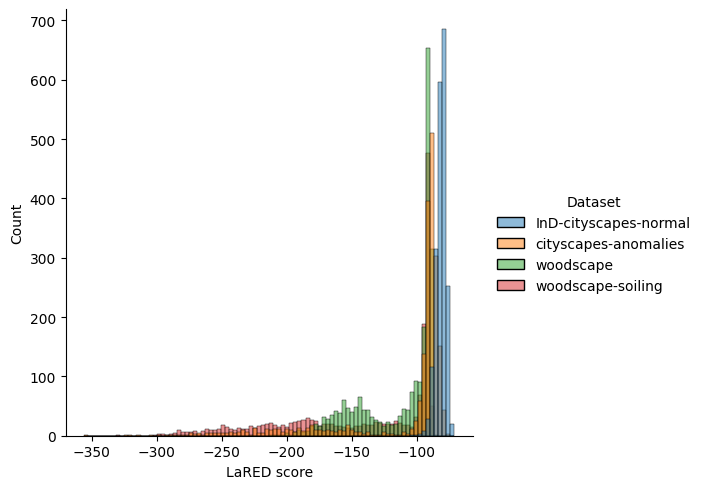

In [295]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_ws_anomal,
                                 df_score_ood_cs,
                                 df_score_ood_ws_soil]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

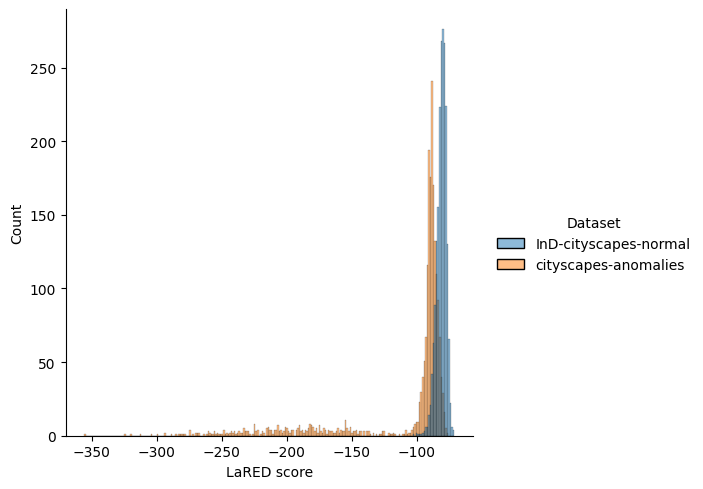

In [296]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_ws_anomal]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

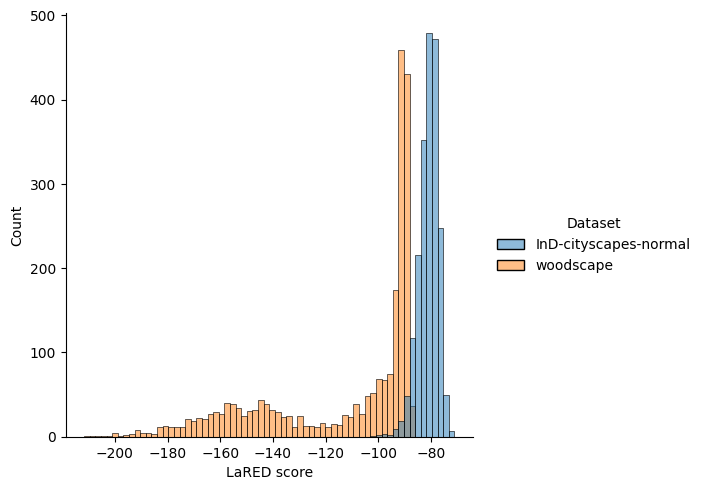

In [297]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_cs]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

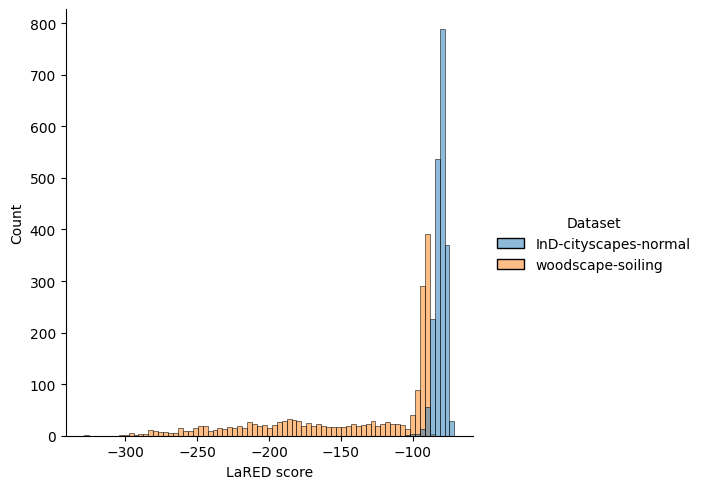

In [298]:
df_h_z_valid_scores = pd.concat([df_score_ind_ws_normal,
                                 df_score_ood_ws_soil]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="LaRED score", hue="Dataset", kind="hist", fill=True)
plt.show()

# Load Entropy

In [103]:
data_path = "./Data/EXPERIMENTS/CVPR-2024/semantic_segmentation/deeplabv3p-cityscapes/embeddings/cityscapes/entropy/"

In [104]:
cs_dlv3p_h_z_cs_normal_train_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_train_samples_np.npy')
cs_dlv3p_h_z_cs_normal_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_valid_samples_np.npy')
cs_dlv3p_h_z_cs_normal_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_normal_test_samples_np.npy')

cs_dlv3p_h_z_cs_anomal_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_anomal_valid_samples_np.npy')
cs_dlv3p_h_z_cs_anomal_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_cs_anomal_test_samples_np.npy')

cs_dlv3p_h_z_ws_256512_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_256512_valid_samples_np.npy')
cs_dlv3p_h_z_ws_256512_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_256512_test_samples_np.npy')

cs_dlv3p_h_z_ws_soil_256512_valid_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.npy')
cs_dlv3p_h_z_ws_soil_256512_test_samples_np = np.load(data_path + 'cs_dlv3p_h_z_ws_soil_256512_test_samples_np.npy')

# Build Deeplabv3+-Cityscapes LaREM Distribution Shift Detector 

In [12]:
ic(cs_dlv3p_h_z_cs_normal_train_samples_np.shape);
ic(cs_dlv3p_h_z_cs_normal_valid_samples_np.shape);
ic(cs_dlv3p_h_z_cs_normal_test_samples_np.shape);

ic(cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape);
ic(cs_dlv3p_h_z_cs_anomal_test_samples_np.shape);

ic(cs_dlv3p_h_z_ws_256512_valid_samples_np.shape);
ic(cs_dlv3p_h_z_ws_256512_test_samples_np.shape);

ic(cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape);
ic(cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape);

ic| cs_dlv3p_h_z_cs_normal_train_samples_np.shape: (2975, 2048)
ic| cs_dlv3p_h_z_cs_normal_valid_samples_np.shape: (500, 2048)
ic| cs_dlv3p_h_z_cs_normal_test_samples_np.shape: (1525, 2048)
ic| cs_dlv3p_h_z_cs_anomal_valid_samples_np.shape: (500, 2048)
ic| cs_dlv3p_h_z_cs_anomal_test_samples_np.shape: (1525, 2048)
ic| cs_dlv3p_h_z_ws_256512_valid_samples_np.shape: (1482, 2048)
ic| cs_dlv3p_h_z_ws_256512_test_samples_np.shape: (823, 2048)
ic| cs_dlv3p_h_z_ws_soil_256512_valid_samples_np.shape: (800, 2048)
ic| cs_dlv3p_h_z_ws_soil_256512_test_samples_np.shape: (1000, 2048)


## Build Detector LaREM

In [13]:
from sklearn.covariance import EmpiricalCovariance

class LaREMPostprocessor:
    def __init__(self,
                 setup_flag: bool = False,
                 get_2d_rep_mean: bool = False):

        self.setup_flag = setup_flag
        self.get_2d_rep_mean = get_2d_rep_mean
        self.feats_mean = None
        self.precision = None

    def setup(self,
              ind_feats: np.ndarray):
        
        if not self.setup_flag:
            # estimate mean and variance from training set
            print('\n Estimating mean and variance from training set...')

            self.feats_mean = ind_feats.mean(0)
            self.feats_mean = np.mean(ind_feats, 0, keepdims=True)
            
            self.centered_data = ind_feats - self.feats_mean
              
            group_lasso = EmpiricalCovariance(assume_centered=False)
            group_lasso.fit(self.centered_data)
            
            self.precision = group_lasso.precision_
            
            self.setup_flag = True
            # we need to use:
            # self.feats_mean & self.precision
        else:
            pass

    def postprocess(self,
                    ood_feats: np.ndarray):
           
        diff = ood_feats - self.feats_mean
        conf_score = -np.diag(np.matmul(np.matmul(diff, self.precision), np.transpose(diff)))

        return conf_score

In [14]:
cs_dlv3p_larem_detector = LaREMPostprocessor()

In [15]:
cs_dlv3p_larem_detector.setup(cs_dlv3p_h_z_cs_normal_train_samples_np)


 Estimating mean and variance from training set...


In [16]:
ic(cs_dlv3p_larem_detector.feats_mean.shape);
ic(cs_dlv3p_larem_detector.precision.shape);

ic| cs_dlv3p_larem_detector.feats_mean.shape: (1, 2048)
ic| cs_dlv3p_larem_detector.precision.shape: (2048, 2048)


In [54]:
ind_cs_valid_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_cs_normal_valid_samples_np)
ic(ind_cs_valid_larem_score.shape);
ind_cs_test_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_cs_normal_test_samples_np)
ic(ind_cs_test_larem_score.shape);


ood_cs_anomal_valid_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_cs_anomal_valid_samples_np)
ic(ood_cs_anomal_valid_larem_score.shape);
ood_cs_anomal_test_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_cs_anomal_test_samples_np)
ic(ood_cs_anomal_test_larem_score.shape);


ood_ws_valid_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_ws_256512_valid_samples_np)
ic(ood_ws_valid_larem_score.shape);
ood_ws_test_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_ws_256512_test_samples_np)
ic(ood_ws_test_larem_score.shape);


ood_ws_soil_valid_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_ws_soil_256512_valid_samples_np)
ic(ood_ws_soil_valid_larem_score.shape);
ood_ws_soil_test_larem_score = cs_dlv3p_larem_detector.postprocess(cs_dlv3p_h_z_ws_soil_256512_test_samples_np)
ic(ood_ws_soil_test_larem_score.shape);

ic| ind_cs_valid_larem_score.shape: (500,)
ic| ind_cs_test_larem_score.shape: (1525,)
ic| ood_cs_anomal_valid_larem_score.shape: (500,)
ic| ood_cs_anomal_test_larem_score.shape: (1525,)
ic| ood_ws_valid_larem_score.shape: (1482,)
ic| ood_ws_test_larem_score.shape: (823,)
ic| ood_ws_soil_valid_larem_score.shape: (800,)
ic| ood_ws_soil_test_larem_score.shape: (1000,)


In [55]:
cs_dlv3p_ind_cs_larem_scores = np.concatenate((ind_cs_valid_larem_score,
                                                        ind_cs_test_larem_score))

cs_dlv3p_ood_cs_anomal_larem_scores = np.concatenate((ood_cs_anomal_valid_larem_score,
                                                      ood_cs_anomal_test_larem_score))

cs_dlv3p_ood_ws_larem_scores = np.concatenate((ood_ws_valid_larem_score,
                                               ood_ws_test_larem_score))

cs_dlv3p_ood_ws_soil_larem_scores = np.concatenate((ood_ws_soil_valid_larem_score,
                                                    ood_ws_soil_test_larem_score))

ic(cs_dlv3p_ind_cs_larem_scores.shape);
ic(cs_dlv3p_ood_cs_anomal_larem_scores.shape);
ic(cs_dlv3p_ood_ws_larem_scores.shape);
ic(cs_dlv3p_ood_ws_soil_larem_scores.shape);

ic| cs_dlv3p_ind_cs_larem_scores.shape: (2025,)


ic| cs_dlv3p_ood_cs_anomal_larem_scores.shape: (2025,)
ic| cs_dlv3p_ood_ws_larem_scores.shape: (2305,)
ic| cs_dlv3p_ood_ws_soil_larem_scores.shape: (1800,)


In [56]:
ic(cs_dlv3p_ind_cs_larem_scores.shape);
ic(cs_dlv3p_ood_cs_anomal_larem_scores.shape);

results_ws_anomal = get_hz_detector_results(detect_exp_name="cityscapes vs. cityscapes-anomalies",
                                            ind_samples_scores=cs_dlv3p_ind_cs_larem_scores,
                                            ood_samples_scores=cs_dlv3p_ood_cs_anomal_larem_scores)

ic| cs_dlv3p_ind_cs_larem_scores.shape: (2025,)
ic| cs_dlv3p_ood_cs_anomal_larem_scores.shape: (2025,)


AUROC: 0.9826
FPR95: 0.0973
AUPR: 0.9834


In [57]:
ic(cs_dlv3p_ind_cs_larem_scores.shape);
ic(cs_dlv3p_ood_ws_larem_scores.shape);

results_cs = get_hz_detector_results(detect_exp_name="cityscapes vs. woodscape",
                                     ind_samples_scores=cs_dlv3p_ind_cs_larem_scores,
                                     ood_samples_scores=cs_dlv3p_ood_ws_larem_scores)

ic| cs_dlv3p_ind_cs_larem_scores.shape: (2025,)
ic| cs_dlv3p_ood_ws_larem_scores.shape: (2305,)


AUROC: 0.9991
FPR95: 0.0000
AUPR: 0.9991


In [58]:
ic(cs_dlv3p_ind_cs_larem_scores.shape);
ic(cs_dlv3p_ood_ws_soil_larem_scores.shape);

results_ws_soil = get_hz_detector_results(detect_exp_name="cityscapes vs. woodscape-soiling",
                                          ind_samples_scores=cs_dlv3p_ind_cs_larem_scores,
                                          ood_samples_scores=cs_dlv3p_ood_ws_soil_larem_scores)

ic| cs_dlv3p_ind_cs_larem_scores.shape: (2025,)


ic| cs_dlv3p_ood_ws_soil_larem_scores.shape: (1800,)


AUROC: 0.9999
FPR95: 0.0000
AUPR: 1.0000


## Plot scores

In [59]:
df_score_ind_cs_normal = pd.DataFrame(cs_dlv3p_ind_cs_larem_scores, columns=["LaREM score"])
df_score_ood_cs_anomal = pd.DataFrame(cs_dlv3p_ood_cs_anomal_larem_scores, columns=["LaREM score"])
df_score_ood_ws = pd.DataFrame(cs_dlv3p_ood_ws_larem_scores, columns=["LaREM score"])
df_score_ood_ws_soil = pd.DataFrame(cs_dlv3p_ood_ws_soil_larem_scores, columns=["LaREM score"])

df_score_ind_cs_normal.insert(0, "Dataset", "")
df_score_ind_cs_normal.loc[:, "Dataset"] = "InD-cityscapes-normal"

df_score_ood_cs_anomal.insert(0, "Dataset", "")
df_score_ood_cs_anomal.loc[:, "Dataset"] = "cityscapes-anomalies"

df_score_ood_ws.insert(0, "Dataset", "")
df_score_ood_ws.loc[:, "Dataset"] = "woodscape"

df_score_ood_ws_soil.insert(0, "Dataset", "")
df_score_ood_ws_soil.loc[:, "Dataset"] = "woodscape-soiling"

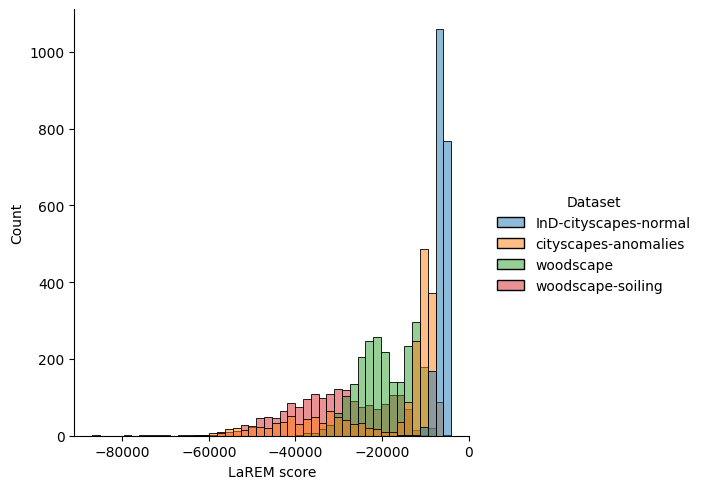

In [60]:
df_larem_scores = pd.concat([df_score_ind_cs_normal,
                             df_score_ood_cs_anomal,
                             df_score_ood_ws,
                             df_score_ood_ws_soil]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

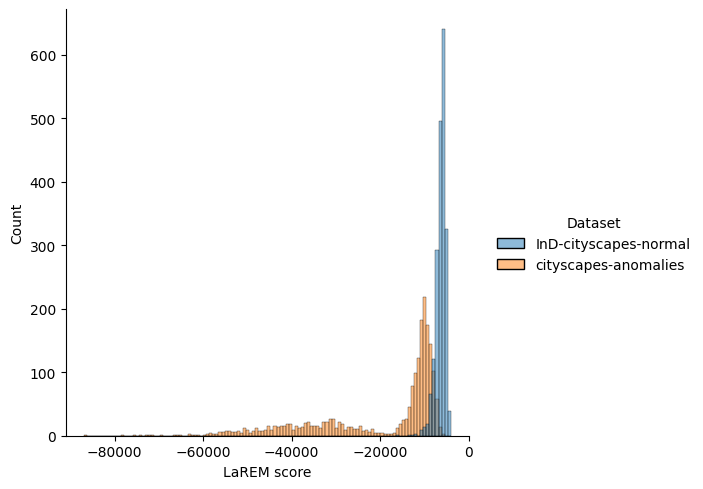

In [64]:
df_larem_scores = pd.concat([df_score_ind_cs_normal,
                             df_score_ood_cs_anomal]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

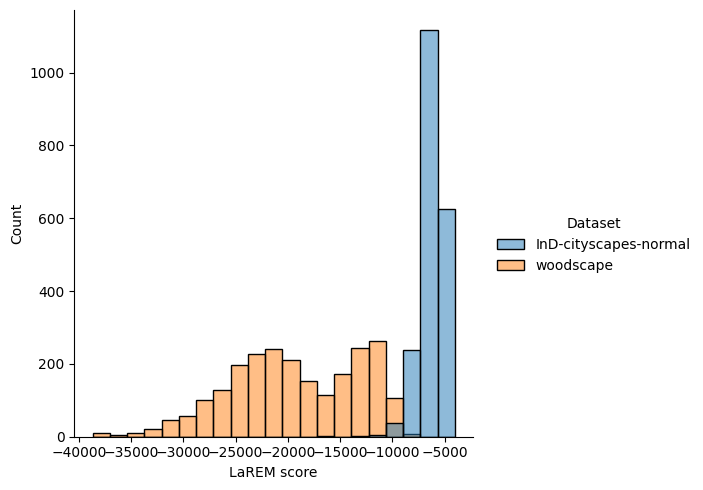

In [65]:
df_larem_scores = pd.concat([df_score_ind_cs_normal,
                             df_score_ood_ws]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

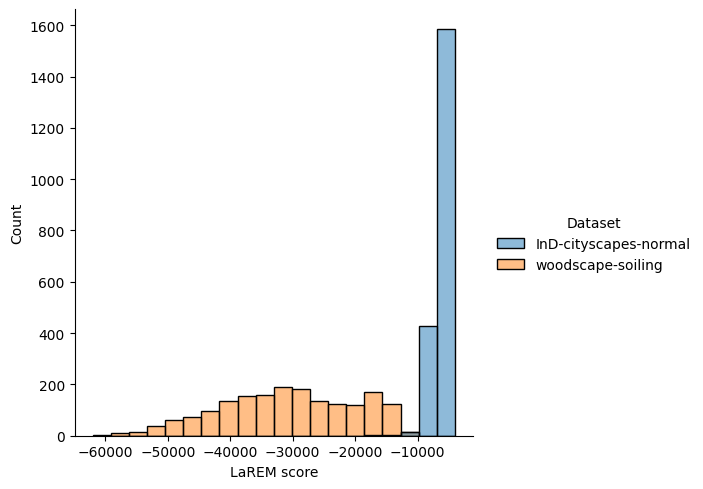

In [66]:
df_larem_scores = pd.concat([df_score_ind_cs_normal,
                             df_score_ood_ws_soil]).reset_index(drop=True)

sns.displot(df_larem_scores, x="LaREM score", hue="Dataset", kind="hist", fill=True)
plt.show()

# Samples Predictions

In [45]:
ic(batch_cs_data.shape);
ic(batch_ws_data.shape);
ic(batch_ws_anomal_data.shape);
ic(batch_ws_soil_data.shape);

ic| batch_cs_data.shape: torch.Size([1, 3, 256, 512])


ic| batch_ws_data.shape: torch.Size([1, 3, 256, 512])
ic| batch_ws_anomal_data.shape: torch.Size([1, 3, 256, 512])
ic| batch_ws_soil_data.shape: torch.Size([1, 3, 256, 512])


In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
def get_mc_pred_samples(dnn_model, batch_sample_data, sample_labels, mc_samples_nro=16):
    dnn_model.to(device)
    batch_sample_data = batch_sample_data.to(device)
    sample_labels = sample_labels.to(device)
    mcd_samples_y_pred = []
    s = torch.nn.Softmax(dim=1)
    
    with torch.no_grad():
        for i in range(mc_samples_nro):
            y_pred = dnn_model(batch_sample_data)
            mcd_samples_y_pred.append(y_pred)
            # mcd_samples_z_prior.append(dnn_model.prob_unet_model.z_prior_sample)

    mcd_samples_y_pred_t = torch.cat(mcd_samples_y_pred, dim=0)
    # mcd_samples_z_pred_t = torch.cat(mcd_samples_z_prior, dim=0)
    y_pred_prob_t = s(mcd_samples_y_pred_t)

    return mcd_samples_y_pred_t, y_pred_prob_t

In [48]:
def get_pred_entropy(y_pred_prob_t):
    y_pred_prob_mean_t = torch.mean(y_pred_prob_t, 0, True)
    predictive_entropy = -torch.sum((y_pred_prob_mean_t * torch.log(y_pred_prob_mean_t)), dim=1)
    # pred_mask = torch.argmax(y_pred_prob_t, dim=1)
    pred_mask = torch.argmax(y_pred_prob_mean_t, dim=1)  # get label from the mean of the predictions
    return pred_mask, predictive_entropy

## Prediction Samples Woodscape Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


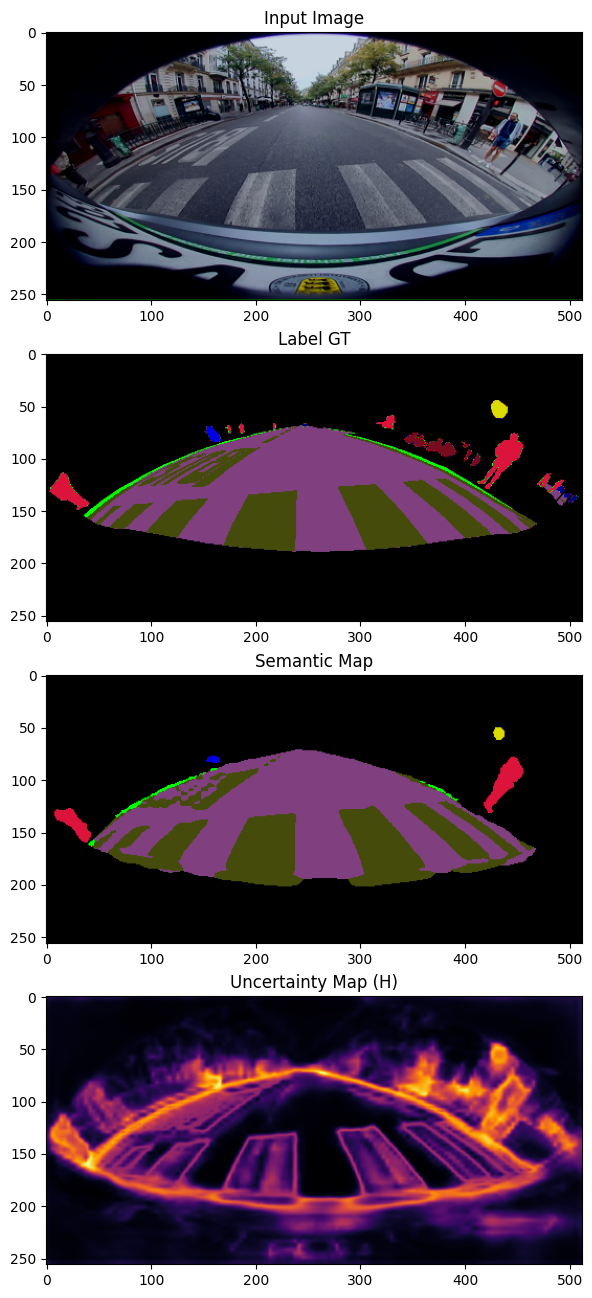

In [245]:
mcd_pred_samples, y_pred_probs = get_mc_pred_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                     batch_ws_data, batch_ws_labels,
                                                     mc_samples_nro=16)

pred_map, pred_h_map = get_pred_entropy(y_pred_probs)


show_prediction_uncertainty_images(batch_ws_data[0],
                                   pred_map,
                                   pred_h_map[0],
                                   ws_dm_normal_dlv3p_256_512.woodscape_ds_train.decode_segmap,
                                   size=(256, 512),
                                   label=batch_ws_labels[0])

## Prediction Samples Woodscape Anomal Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


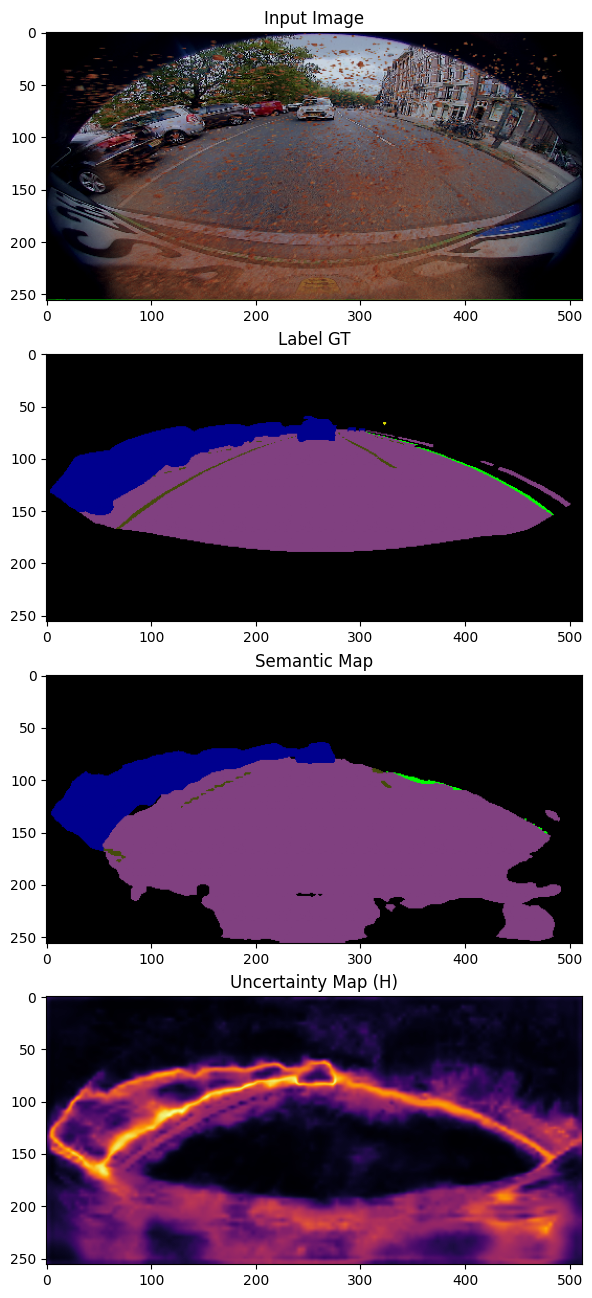

In [230]:
mcd_pred_samples, y_pred_probs = get_mc_pred_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                     batch_ws_anomal_data, batch_ws_anomal_labels,
                                                     mc_samples_nro=16)

pred_map, pred_h_map = get_pred_entropy(y_pred_probs)


show_prediction_uncertainty_images(batch_ws_anomal_data[0],
                                   pred_map,
                                   pred_h_map[0],
                                   ws_dm_normal_dlv3p_256_512.woodscape_ds_train.decode_segmap,
                                   size=(256, 512),
                                   label=batch_ws_anomal_labels[0])

## Prediction Samples Woodscape Soiling Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


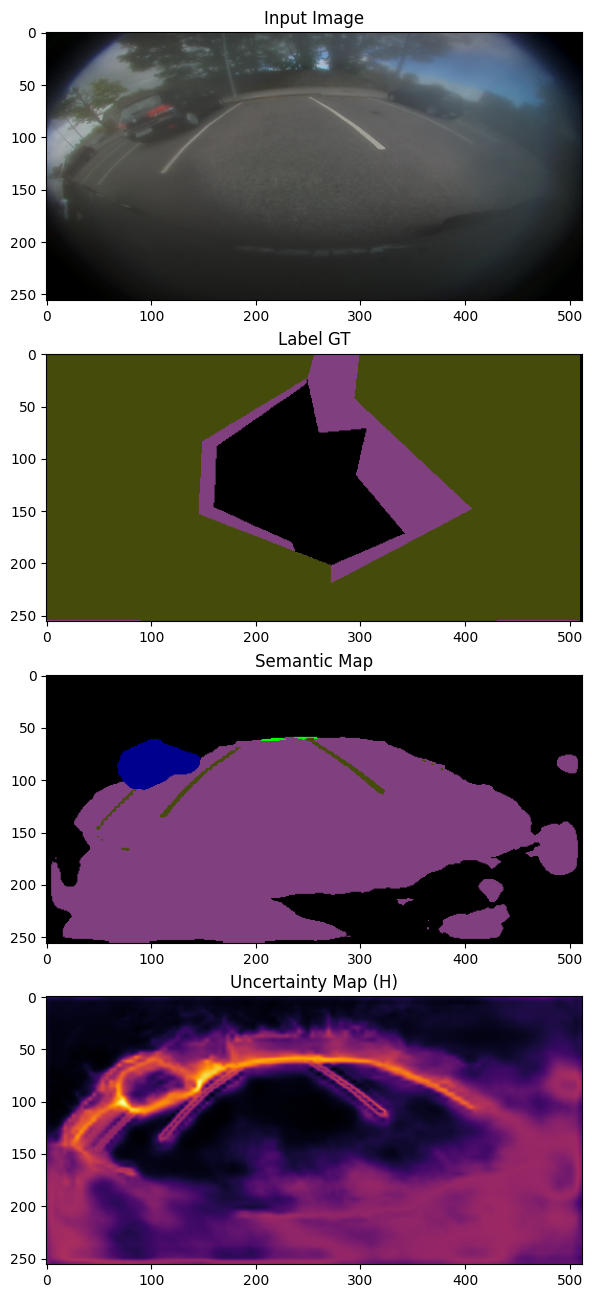

In [190]:
mcd_pred_samples, y_pred_probs = get_mc_pred_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                     batch_ws_soil_data, batch_ws_soil_labels,
                                                     mc_samples_nro=16)

pred_map, pred_h_map = get_pred_entropy(y_pred_probs)


show_prediction_uncertainty_images(batch_ws_soil_data[0],
                                   pred_map,
                                   pred_h_map[0],
                                   ws_dm_normal_dlv3p_256_512.woodscape_ds_train.decode_segmap,
                                   size=(256, 512),
                                   label=batch_ws_soil_labels[0])

## Prediction Samples Cityscapes Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


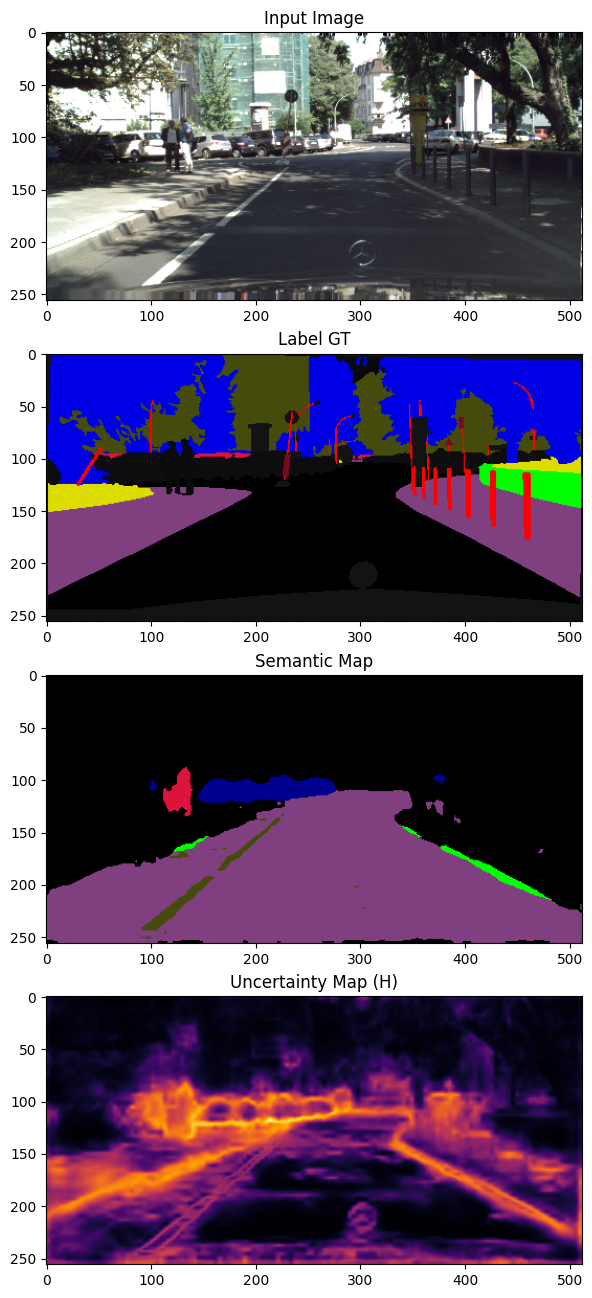

In [156]:
mcd_pred_samples, y_pred_probs = get_mc_pred_samples(ws_dlv3p_model.deeplab_v3plus_model,
                                                     batch_cs_data, batch_cs_labels,
                                                     mc_samples_nro=16)

pred_map, pred_h_map = get_pred_entropy(y_pred_probs)


show_prediction_uncertainty_images(batch_cs_data[0],
                                   pred_map,
                                   pred_h_map[0],
                                   ws_dm_normal_dlv3p_256_512.woodscape_ds_train.decode_segmap,
                                   size=(256, 512),
                                   label=batch_cs_labels[0]
                                #    label=batch_cs_labels[0]
                                )